#Import Libraries

In [1]:
!pip install unidecode

     |████████████████████████████████| 245kB 22.8MB/s 


In [2]:
!pip install transformers

     |████████████████████████████████| 1.3MB 22.5MB/s 
     |████████████████████████████████| 2.9MB 49.7MB/s 
     |████████████████████████████████| 890kB 46.4MB/s 
     |████████████████████████████████| 1.1MB 41.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=89cd8356d56ad50d9a95a26a51749852a22ec5606d51bdd18dd4211d3f3aa8d4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Import libraries
import requests
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime as dt
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')


from textblob import TextBlob
from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import CountVectorizer

# For Natural Language Processing
import re
import unidecode
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords



# For classification modeling
from sklearn.model_selection import train_test_split, cross_val_score 
import transformers
import torch

# For evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score , roc_auc_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Import Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/My Drive/BT4222_final_project

/content/drive/.shortcut-targets-by-id/16vnekamxpJVMJAmjRS55-3XVIucfR-2H/BT4222_final_project


In [6]:
df = pd.read_csv('./data/combined_df.csv')
df

,created_utc,url,id,num_comments,title,subreddit,timestamp,is_onion
0,1604822052,https://www.reddit.com/r/TheOnion/comments/jq7...,jq7ziz,1,"This, this makes me laugh (and strap on my gas...",TheOnion,2020-11-08 07:54:12,1
1,1604817507,https://www.reddit.com/r/TheOnion/comments/jq7...,jq75xn,0,"""Biden admits he expected to be president by n...",TheOnion,2020-11-08 06:38:27,1
2,1604809460,https://www.reddit.com/r/TheOnion/comments/jq5...,jq5g4c,0,Donald Trump Jr. Refuses To Step Down From Pos...,TheOnion,2020-11-08 04:24:20,1
3,1604780609,https://www.reddit.com/r/TheOnion/comments/jpx...,jpxkhp,2,[Italian TheOnion] Trump declare victory in Ne...,TheOnion,2020-11-07 20:23:29,1
4,1604776395,https://www.reddit.com/r/TheOnion/comments/jpw...,jpw90t,5,Crying Eric Trump Asks Father If They Poor Now,TheOnion,2020-11-07 19:13:15,1
...,...,...,...,...,...,...,...,...
16461,1599245757,https://www.reddit.com/r/nottheonion/comments/...,imlyba,15,Conservative MP’s husband calls coronavirus a ...,nottheonion,2020-09-04 18:55:57,0
16462,1599244738,https://www.reddit.com/r/nottheonion/comments/...,imlmuy,10,Ohio woman calls police over phallic-shaped me...,nottheonion,2020-09-04 18:38:58,0
16463,1599244644,https://www.reddit.com/r/nottheonion/comments/...,imlltu,2,Uzbek Imam Declares That Thinking Of Another M...,nottheonion,2020-09-04 18:37:24,0
16464,1599244429,https://www.reddit.com/r/nottheonion/comments/...,imljg5,10,Terror-accused teenager said he was 'nine to 1...,nottheonion,2020-09-04 18:33:49,0


# Data Preprocessing

In [ ]:
# Preprocessing function
def titles_to_words(raw_title):
    
    # Get rid of accents
    unaccented = unidecode.unidecode(raw_title)
    
    # Get rid of punctuation0-9]", " ", unaccented)
    letters_only = re.sub("[^a-zA-Z]", " ", unaccented)

    # Get all lowercase words
    words = letters_only.lower().split()
    
    # Instantiate and run Lemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in words]
    
    # Remove stop words
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    # Join into string and return the result.
    return(" ".join(meaningful_words))

In [ ]:
df['clean_title'] = [titles_to_words(title) for title in df['title']]
df = df.sample(frac = 1, random_state=4222) 
df

,created_utc,url,id,num_comments,title,subreddit,timestamp,is_onion,clean_title
13433,1601344240,https://www.reddit.com/r/nottheonion/comments/...,j1pw9i,3,Teacher says he can no longer teach kindergart...,nottheonion,2020-09-29 01:50:40,0,teacher says longer teach kindergarten parent ...
14011,1600905291,https://www.reddit.com/r/nottheonion/comments/...,iymamb,2,Mike Pence is being played by a gay man in moc...,nottheonion,2020-09-23 23:54:51,0,mike pence played gay man mock debates kamala ...
5046,1541427930,https://www.reddit.com/r/TheOnion/comments/9ud...,9udwtl,0,"The Week In Pictures – Week Of November 5, 2018",TheOnion,2018-11-05 14:25:30,1,week pictures week november
8168,1521484778,https://www.reddit.com/r/TheOnion/comments/85l...,85lv3i,0,Andrew McCabe Spending Few Days As Congression...,TheOnion,2018-03-19 18:39:38,1,andrew mccabe spending days congressional bath...
2796,1557857406,https://www.reddit.com/r/TheOnion/comments/bom...,bome1h,0,Urgent Health Warning: The Surgeon General Has...,TheOnion,2019-05-14 18:10:06,1,urgent health warning surgeon general issued r...
...,...,...,...,...,...,...,...,...,...
12636,1601920847,https://www.reddit.com/r/nottheonion/comments/...,j5odk1,17,Flawless 102-carat diamond a 'bargain' at $16m,nottheonion,2020-10-05 18:00:47,0,flawless carat diamond bargain
3031,1556042834,https://www.reddit.com/r/TheOnion/comments/bgj...,bgjm9r,1,No One Else Wants This: Dad Is Facing Backlash...,TheOnion,2019-04-23 18:07:14,1,one else wants dad facing backlash making exec...
8057,1522170993,https://www.reddit.com/r/TheOnion/comments/87k...,87k7vc,0,Most Influential U.S. Secretaries Of State,TheOnion,2018-03-27 17:16:33,1,influential u secretaries state
2036,1568219807,https://www.reddit.com/r/TheOnion/comments/d2s...,d2syct,1,Issue 37•34,TheOnion,2019-09-11 16:36:47,1,issue


# Classification

In [7]:
data_texts = df["title"].to_list() # Features (not-tokenized yet)
data_labels = df["is_onion"].to_list() # Labels

In [9]:
x_train, x_val, y_train, y_val = train_test_split(data_texts, data_labels, test_size=0.3, random_state=4222)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.01, random_state=4222)

In [16]:
import transformers

tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

In [18]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

In [25]:
model = transformers.TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_79 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=5, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/5
714/714 [==============================] - 367s 514ms/step - loss: 0.4553 - accuracy: 0.7889 - val_loss: 0.3802 - val_accuracy: 0.8273
Epoch 2/5
714/714 [==============================] - 366s 513ms/step - loss: 0.2655 - accuracy: 0.8897 - val_loss: 0.3467 - val_accuracy: 0.8573
Epoch 3/5
714/714 [==============================] - 366s 512ms/step - loss: 0.1629 - accuracy: 0.9404 - val_loss: 0.3823 - val_accuracy: 0.8636
Epoch 4/5
714/714 [==============================] - 366s 512ms/step - loss: 0.0955 - accuracy: 0.9683 - val_loss: 0.4596 - val_accuracy: 0.8654
Epoch 5/5
714/714 [==============================] - 365s 511ms/step - loss: 0.0579 - accuracy: 0.9833 - val_loss: 0.4988 - val_accuracy: 0.8700


In [53]:
# save the model and tokenizer

save_directory = "./bert_models" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./bert_models/tokenizer_config.json',
 './bert_models/special_tokens_map.json',
 './bert_models/vocab.txt',
 './bert_models/added_tokens.json')

In [11]:
# load the model and tokenizer
save_directory = "./bert_models/bert_models"
loaded_tokenizer = transformers.DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = transformers.TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at ./bert_models/bert_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_159']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./bert_models/bert_models and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# predict test set
pred_df = pd.DataFrame(columns=['text', 'pred', 'ground_truth'])
for (test_text, true) in zip(x_test,y_test):
    predict_input = loaded_tokenizer.encode(test_text,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    pred_df = pred_df.append({
        'text': test_text,
        'pred': prediction_value,
        'ground_truth': true
    }, ignore_index=True)

pred_df

,text,pred,ground_truth
0,Trump devotee who used to be in depresdiac sio...,0,0
1,All that plywood tells you the real post-elect...,0,0
2,New Study Reveals Most Children Unrepentant So...,1,1
3,Biden Wins! We have been waiting for this day ...,1,0
4,TGI Fridays Is A Human Right,0,1
...,...,...,...
111,Billionaire fortunes hit record high during pa...,0,0
112,Frustrated Nursing Student Unable To Draw Bloo...,1,1
113,Bakker: Masks Are Satanic Because They Block P...,0,0
114,Transgender Satanist anarchist wins Republican...,0,0


In [24]:
acc = accuracy_score(pred_df['pred'].astype(int), pred_df['ground_truth'].astype(int))
f1 = f1_score(pred_df['pred'].astype(int), pred_df['ground_truth'].astype(int))
roc = roc_auc_score(pred_df['pred'].astype(int), pred_df['ground_truth'].astype(int))

print(acc)
print(f1)
print(roc)

0.9051724137931034
0.9133858267716536
0.9029271206690561


In [61]:
import keras.backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

print(recall_m(pred_df['ground_truth'].astype('float64'),pred_df['pred'].astype('float64')))

print(precision_m(pred_df['ground_truth'].astype('float64'),pred_df['pred'].astype('float64')))

print(f1_m(pred_df['ground_truth'].astype('float64'),pred_df['pred'].astype('float64')))

tf.Tensor(0.8923076909349114, shape=(), dtype=float64)
tf.Tensor(0.9354838694588969, shape=(), dtype=float64)
tf.Tensor(0.9133857753611536, shape=(), dtype=float64)


In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

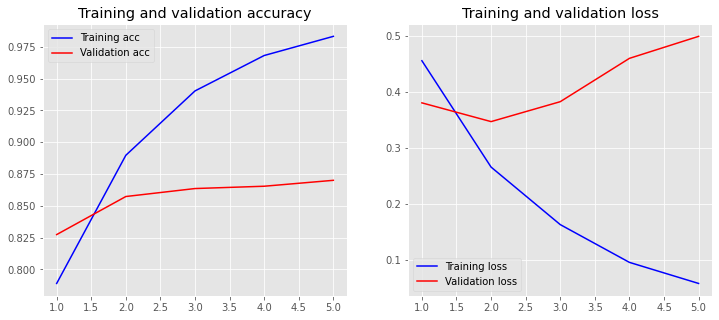

In [28]:
plot_history(model.history)

In [8]:
# predict on new data
new_df_fake = pd.read_csv('Fake.csv')
new_df_fake = new_df_fake[['title']]
new_df_fake['is_fake'] = 1
new_df_fake

,title,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,1
23479,How to Blow $700 Million: Al Jazeera America F...,1


In [9]:
new_df_true = pd.read_csv('True.csv')
new_df_true = new_df_true[['title']]
new_df_true['is_fake'] = 0
new_df_true

,title,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,0
21413,LexisNexis withdrew two products from Chinese ...,0
21414,Minsk cultural hub becomes haven from authorities,0
21415,Vatican upbeat on possibility of Pope Francis ...,0


In [10]:
new_df = new_df_fake.append(new_df_true)
new_df = new_df.sample(frac=0.05)
new_df['title'] = [title for title in new_df['title']]
new_df

,title,is_fake
6683,Hillary NAILS Response To Trump’s Accusations...,1
15488,Lebanon PM under house arrest in Saudi Arabia:...,0
23402,President Obama Arrives in Cuba,1
7471,Jimmy Fallon Destroys Trump University In Hil...,1
13765,Kuwait court sentences MPs to jail terms for s...,0
...,...,...
9579,"Ryan, Trump cite 'positive step' toward Republ...",0
6824,Democrats plot uphill fight against some Trump...,0
6262,Two Stunning New Polls Show These Staunch Red...,1
12010,"Scuffles, flares as Albania picks interim pros...",0


In [ ]:
def pred_using_bert(text):
    predict_input = loaded_tokenizer.encode(text,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    print(prediction_value)
    return prediction_value

new_df['pred'] = [pred_using_bert(title) for title in new_df['title']]
new_df

In [12]:
accuracy_score(new_df['is_fake'], new_df['pred'])

0.5652561247216036